# Performance of NPB-C++



In [7]:
%pip install --upgrade plotly numpy nbformat kaleido pandas

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import glob
from pathlib import Path
import plotly.express as px
from IPython.display import display, Image

anonymizer = True
force = False

root_dir = Path.cwd()

def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<fuzzy-pytorch>")
    return Path(path_str)

results_dir = root_dir / "run-SER"
print("Results directory:", anondir(results_dir))

Results directory: <fuzzy-pytorch>/run-SER


## Parse results

In [9]:
# Load the results from text files


def load_results(directory, tool, bench, size):
    pattern = directory / f"{tool}_{bench}_{size}_results" / "**" / "stdout"
    files = glob.glob(str(pattern.resolve()), recursive=True)
    values = {}
    for file in files:
        repetition = file.split("/")[-2]
        with open(file, "r") as f:
            for line in f:
                if "Time in seconds =" in line:
                    time_str = line.split("=")[1].strip()
                    values["Time"] = values.get("Time", []) + [float(time_str)]
                elif "Mop/s total" in line:
                    mop_str = line.split("=")[1].strip()
                    values["Mops"] = values.get("Mops", []) + [float(mop_str)]
            values["Tool"] = tool
            values["Bench"] = bench
            values["Class"] = size
            values["Repetition"] = values.get("Repetition", []) + [repetition]
    return pd.DataFrame(values)

In [16]:
bench = ["BT", "CG", "EP", "FT", "LU", "MG", "SP"]
size = ["S", "A"]
tools = [
    "cadna",
    "ieee",
    "prism_sr_dynamic",
    "prism_sr_static",
    "prism_ud_static",
    "prism_ud_dynamic",
    "sr",
    "verificarlo",
    "verrou_cestac",
    "verrou_sr",
]

stats_file = root_dir / "perf-NPB-SER-stats.csv"

if force or not stats_file.exists():
    results = pd.DataFrame()
    for b in bench:
        for s in size:
            for t in tools:
                df = load_results(directory=results_dir, tool=t, bench=b.lower(), size=s)
                results = pd.concat([results, df], ignore_index=True)

    results["Variant"] = results["Tool"].str.split("_").str[1]
    display(results)

## Compute statistics

In [ ]:
if force or not stats_file.exists():
    # Compute the reference (ieee) time for each repetition, bench, and class
    ieee_times = results[results["Tool"] == "ieee"][
        ["Bench", "Class", "Repetition", "Time"]
    ].rename(columns={"Time": "Time_ieee"})

    # Merge ieee times into the results DataFrame
    results = results.merge(ieee_times, on=["Bench", "Class", "Repetition"], how="left")

    # Compute slowdown
    results["Time_slowdown"] = results["Time"] / results["Time_ieee"]

    results_stats = (
        results.groupby(["Tool", "Bench", "Class"])
        .agg(
            {
                "Time": ["mean", "std"],
                "Mops": ["mean", "std"],
                "Time_slowdown": ["mean", "std"],
            }
        )
        .reset_index()
    )
    # Flatten MultiIndex columns
    results_stats.columns = [
        "_".join(filter(None, col)).strip("_") for col in results_stats.columns.values
    ]
    # Merge the Variant columns into a single 'Variant' column
    results_stats["Variant"] = results_stats["Tool"].str.split("_").str[1]
    results_stats["Variant"] = results_stats["Variant"].fillna("")
    results_stats.to_csv(stats_file, index=False)

## Figure

In [19]:
colors_map = {
    "IEEE": "#a80ca8",
    "Verrou": "#ff7f0e",
    "PRISM": "#1f77b4",
    "CESTAC": "#1fb438",
    "FM SR": "#26b7e4",
    "MCA RR": "#f10202",
}

In [49]:
results_stats = pd.read_csv(stats_file)
results_stats.fillna("", inplace=True)
results_stats = results_stats[
    ~results_stats["Tool"].isin(["ieee", "prism_sr_dynamic", "prism_ud_dynamic"])
]
colors_discrete_map = {
    "cadna": colors_map["CESTAC"],
    "ieee": colors_map["IEEE"],
    "prism_sr_static": colors_map["PRISM"],
    "prism_ud_static": colors_map["PRISM"],
    "sr": colors_map["FM SR"],
    "verificarlo": colors_map["MCA RR"],
    "verrou_cestac": colors_map["Verrou"],
    "verrou_sr": colors_map["Verrou"],
}
fig = px.bar(
    results_stats,
    x="Time_slowdown_mean",
    y="Bench",
    error_x="Time_slowdown_std",
    color="Tool",
    barmode="group",
    color_discrete_map=colors_discrete_map,
    pattern_shape="Variant",
    pattern_shape_sequence=["", "", "/", "/", "/", "/", "/", "/", "/"],
    facet_col="Class",
    title="",
    labels={"Time": "Time in seconds", "Bench": "Benchmark"},
    height=1200,
    width=1200,
    category_orders={
        "Tool": [
            "prism_ud_static",
            "prism_sr_static",
            "cadna",
            "verrou_cestac",
            "verrou_sr",
            "sr",
            "verificarlo",
        ],
        "Class": ["S", "A"],
    },
)
fig.update_traces(selector=dict(type="bar"), marker_line_width=1.5)
fig.update_layout(
    legend_orientation="h",
    legend_yanchor="top",
    legend_y=1.08,
    legend_xanchor="center",
    legend_x=0.5,
    legend_title_text="Method",
    yaxis_categoryorder="array",
    yaxis_categoryarray=["ep", "cg", "ft", "sp", "mg", "bt", "lu"],
    yaxis2_categoryorder="array",
    yaxis2_categoryarray=["ep", "cg", "ft", "sp", "mg", "bt", "lu"],
    legend_traceorder="normal",
    font_size=20,
    font_family="Helvetica, sans-serif",
)
# Set custom legend/group order
custom_order = [
    "prism_ud_static, ud",
    "prism_sr_static, sr",
    "cadna, ",
    "sr, ",
    "verrou_cestac, cestac",
    "verrou_sr, sr",
    "verificarlo, ",
]
# Update legend names for clarity
legend_rename = {
    "prism_sr_static, sr": "PRISM SR",
    "cadna, ": "CESTAC",
    "verrou_sr, sr": "Verrou SR",
    "verificarlo, ": "MCA RR",
    "prism_ud_static, ud": "PRISM UD",
    "verrou_cestac, cestac": "Verrou CESTAC",
    "sr, ": "FM SR",
}
legend_group = {
    "prism_sr_static, sr": "PRISM",
    "cadna, ": "CESTAC",
    "verrou_sr, sr": "Verrou",
    "verificarlo, ": "MCA RR",
    "prism_ud_static, ud": "PRISM",
    "verrou_cestac, cestac": "Verrou",
    "sr, ": "FM SR",
}

for i, name in enumerate(custom_order):
    for trace in fig.data:
        if trace.name in legend_rename:
            trace.legendgroup = legend_group[trace.name]
            trace.name = legend_rename[trace.name]
for i, name in enumerate(custom_order):
    for trace in fig.data:
        if trace.name == name:
            trace.legendrank = i

fig.update_xaxes(exponentformat="power", title="Slowdown (relative to IEEE)")

# fig.update_xaxes(col=1, title="Class S")
# fig.update_xaxes(col=2, title="Class A")

# # Swap the plots
# fig.update_layout(
#     xaxis=dict(domain=[0.51, 1], title="Slowdown (relative to IEEE)"),
#     xaxis2=dict(domain=[0, 0.49], title="Slowdown (relative to IEEE)"),
# )

# # Update annotations
# fig.layout.annotations[0].update(x=0.755)
# fig.layout.annotations[1].update(x=0.245)

fig.show()

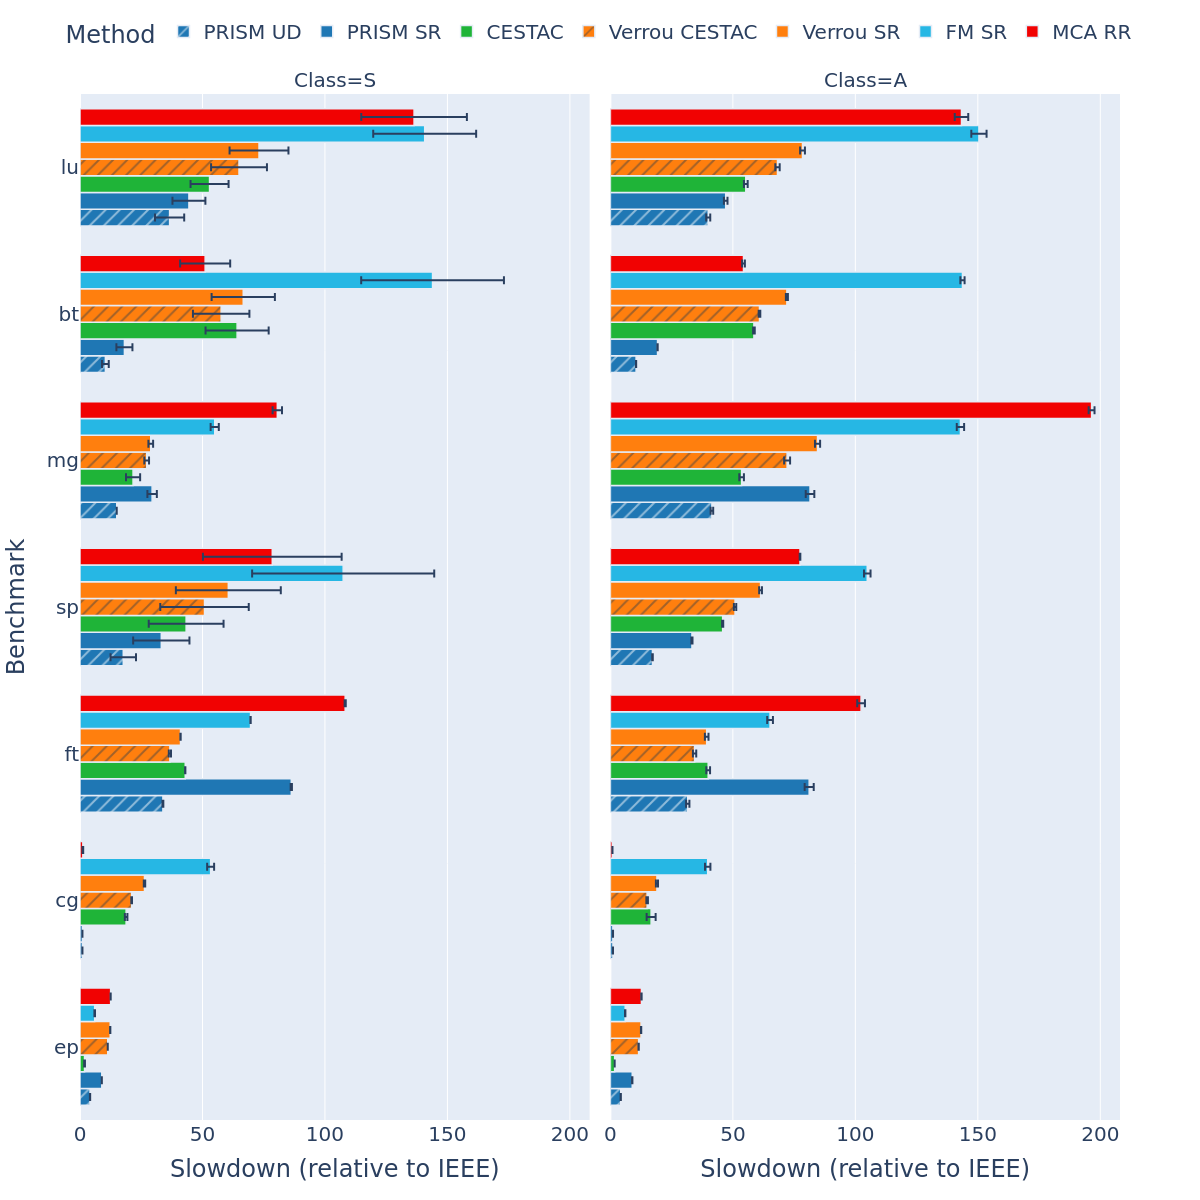

In [50]:
display(Image(fig.to_image(width=fig.layout.width, height=fig.layout.height)))
fig.write_image("perf-NPB-SER-barplot.pdf", width=fig.layout.width, height=fig.layout.height)
